# Fourier Feature INR (Implicit Neural Representation) for BraTS 2023 Tumour Segmentation (JAX)

This notebook implements a coordinate-based MLP (implicit neural representation) with Fourier feature embeddings trained to predict voxel-wise tumour labels for BraTS 2023 volumes.

Instead of a 3D CNN (e.g. nnU-Net), we treat segmentation as learning a function: 
$( f: (x,y,z, m_{t1n}, m_{t1c}, m_{t2w}, m_{t2f}) 	o 	\ext{class logits} $).

We sample coordinates and associated multi-modal intensities to train an MLP with Fourier features for higher frequency representation capacity.

Notes: 
- This is a proof-of-concept; full convergence requires many iterations.
- Memory/time constraints mean we sample sparse coordinates per step.
- BraTS labels: 0=background, 1=NCR/NET, 2=ED, 3=ET.
- Dice scores are computed per class on a validation case.
- Compare conceptually to nnU-Net (dense 3D convolutions + data augmentation).


In [1]:
# Imports
import os, math, json, time, pathlib, functools
from typing import Tuple, Dict, Any
import numpy as np
import jax
import jax.numpy as jnp
import optax
import nibabel as nib
from dataclasses import dataclass

print('JAX devices:', jax.devices())


JAX devices: [CpuDevice(id=0)]


In [ ]:
# Configuration (Enhanced + Cross-Validation)
DATA_ROOT = pathlib.Path('../data/BraTS-2023')  # dataset root
SAVE_PATH = pathlib.Path('../artifacts/inr_brats23.npz')
CASE_LIMIT = 128                  # Max cases to use (subset of full set)
NUM_FOLDS = 5                     # K for K-fold cross-validation
FOLD_INDEX = 0                    # Which fold acts as validation/test (0-based)
GLOBAL_BATCH_SIZE = 32768
MICRO_BATCH_SIZE = 2048
FOURIER_FREQS = 4
HIDDEN_DIMS = [128, 256, 256, 128]
LR = 2e-3
MIN_LR = 2e-4
WARMUP_STEPS = 50
TRAIN_STEPS = 1000
VAL_CASE_INDEX = 0
RNG_SEED = 72
NUM_CLASSES = 4
DICE_WEIGHT = 0.2
CLASS_WEIGHTS = [1.0,1.0,1.0,1.0]
CLIP_NORM = 1.0
# ACCUM steps derived from global vs micro batch
ACCUM_STEPS = (GLOBAL_BATCH_SIZE + MICRO_BATCH_SIZE - 1)//MICRO_BATCH_SIZE
print(f'Using CASE_LIMIT={CASE_LIMIT} NUM_FOLDS={NUM_FOLDS} FOLD_INDEX={FOLD_INDEX}')
jax_key = jax.random.PRNGKey(RNG_SEED)


Using CASE_LIMIT=128 NUM_FOLDS=5 FOLD_INDEX=0


## Data Loading Utilities
We load each BraTS case's modalities and segmentation. Modalities are z-score normalized per volume.

In [3]:
MODALITY_SUFFIXES = ['t1n', 't1c', 't2w', 't2f']
SEG_SUFFIX = 'seg'

def find_cases(root: pathlib.Path):
    cases = []
    for p in sorted(root.iterdir()):
        if p.is_dir():
            if any((p / f'{p.name}-{m}.nii.gz').exists() for m in MODALITY_SUFFIXES):
                cases.append(p)
    return cases

def load_case(case_dir: pathlib.Path):
    base = case_dir.name
    mods = []
    for suf in MODALITY_SUFFIXES:
        fp = case_dir / f'{base}-{suf}.nii.gz'
        img = nib.load(str(fp))
        arr = img.get_fdata().astype(np.float32)
        mask = arr != 0
        if mask.any():
            mu = arr[mask].mean(); sigma = arr[mask].std() + 1e-6
            arr = (arr - mu) / sigma
        mods.append(arr)
    seg_fp = case_dir / f'{base}-{SEG_SUFFIX}.nii.gz'
    seg = nib.load(str(seg_fp)).get_fdata().astype(np.int16)
    mods_arr = np.stack(mods, axis=0)  # (M,H,W,D)
    return mods_arr, seg

# Discover and subset cases
all_cases_full = find_cases(DATA_ROOT)
subset_cases = all_cases_full[:CASE_LIMIT]
print('Total discovered:', len(all_cases_full), 'Subset used:', len(subset_cases))

# Shuffle cases deterministically and create folds
rng = np.random.default_rng(RNG_SEED)
shuffled = list(subset_cases)
rng.shuffle(shuffled)
# Split into NUM_FOLDS (last folds may differ by 1 if not divisible)
folds = np.array_split(shuffled, NUM_FOLDS)
assert 0 <= FOLD_INDEX < len(folds), 'FOLD_INDEX out of range'
val_cases = list(folds[FOLD_INDEX])
train_cases = [c for i,f in enumerate(folds) if i!=FOLD_INDEX for c in f]
print(f'Fold sizes: {[len(f) for f in folds]} | Train={len(train_cases)} Val={len(val_cases)}')

# Aliases for supervised notation
X_train_cases = train_cases
Y_train_cases = train_cases  # segmentation labels paired implicitly
X_val_cases = val_cases
Y_val_cases = val_cases

# Quick peek
if len(val_cases):
    sm_mods, sm_seg = load_case(val_cases[0])
    print('Example val case modalities shape', sm_mods.shape, 'seg shape', sm_seg.shape)


Total discovered: 1251 Subset used: 128
Fold sizes: [26, 26, 26, 25, 25] | Train=102 Val=26
Example val case modalities shape (4, 240, 240, 155) seg shape (240, 240, 155)


## Coordinate + Feature Sampling
We sample random voxel coordinates and gather their modality intensities and labels for stochastic training.

In [4]:
# Build per-split caches and JAX arrays
def prepare_case_cache(case_paths):
    cache = []
    for cp in case_paths:
        mods, seg = load_case(cp)
        cache.append({'mods': mods, 'seg': seg})
    return cache

train_cache = prepare_case_cache(train_cases)
val_cache = prepare_case_cache(val_cases)
vol_shape = train_cache[0]['mods'].shape[1:]  # (H,W,D)
print('Volume shape (train):', vol_shape)

train_mods = jnp.array(np.stack([c['mods'] for c in train_cache], axis=0))  # (Ct,M,H,W,D)
train_segs = jnp.array(np.stack([c['seg'] for c in train_cache], axis=0))    # (Ct,H,W,D)
val_mods = jnp.array(np.stack([c['mods'] for c in val_cache], axis=0)) if val_cache else None
val_segs = jnp.array(np.stack([c['seg'] for c in val_cache], axis=0)) if val_cache else None

C, M, H, W, D = train_mods.shape  # Use training count for sampling
print('Train arrays:', (C, M, H, W, D), '| Val cases:', len(val_cache))

# Sampling now only draws from training set
def sample_batch(rng_key, batch_size):
    key_case, key_x, key_y, key_z = jax.random.split(rng_key, 4)
    ci = jax.random.randint(key_case, (batch_size,), 0, C)
    xs = jax.random.randint(key_x, (batch_size,), 0, H)
    ys = jax.random.randint(key_y, (batch_size,), 0, W)
    zs = jax.random.randint(key_z, (batch_size,), 0, D)
    def gather(ci_i, x, y, z):
        intens = train_mods[ci_i, :, x, y, z]
        lab = train_segs[ci_i, x, y, z]
        return intens, lab
    intens, labels = jax.vmap(gather)(ci, xs, ys, zs)
    coords = jnp.stack([xs, ys, zs], axis=-1)
    norm_coords = (coords / (jnp.array([H-1, W-1, D-1]))) * 2.0 - 1.0
    return norm_coords, intens, labels.astype(jnp.int32)

# Validation slice helper will use val_mods/val_segs later if needed

test_coords, test_feats, test_labels = sample_batch(jax_key, 4)
print('Sample coords', test_coords.shape, 'feats', test_feats.shape, 'labels', test_labels)


Volume shape (train): (240, 240, 155)
Train arrays: (102, 4, 240, 240, 155) | Val cases: 26
Sample coords (4, 3) feats (4, 4) labels [0 0 0 0]


## Fourier Feature Mapping
We map 3D coordinates (normalized) to a higher-dimensional space using sinusoidal functions.

In [5]:
def fourier_features(coords: jnp.ndarray, k: int) -> jnp.ndarray:
    # coords: (B,3) in [-1,1]
    B, dim = coords.shape
    freqs = jnp.arange(1, k+1)  # (k,)
    # shape (B, dim, k)
    ang = coords[..., None] * freqs[None, None, :] * math.pi
    sin = jnp.sin(ang); cos = jnp.cos(ang)
    ff = jnp.concatenate([sin, cos], axis=-1).reshape(B, dim * 2 * k)
    return ff

def build_input(coords, intensities):
    ff = fourier_features(coords, FOURIER_FREQS)
    return jnp.concatenate([coords, ff, intensities], axis=-1)

in_dim_test = build_input(test_coords, test_feats).shape[-1]
print('Input dim:', in_dim_test)


Input dim: 31


## MLP Definition (Pure Functions)
We define simple MLP parameter initialization and forward apply.

In [6]:
def glorot(key, shape):
    fan_in, fan_out = shape[0], shape[1]
    limit = math.sqrt(6.0 / (fan_in + fan_out))
    return jax.random.uniform(key, shape, minval=-limit, maxval=limit)

def init_mlp(key, in_dim, hidden_dims, out_dim):
    params = []
    dims = [in_dim] + hidden_dims + [out_dim]
    for i in range(len(dims)-1):
        key, k1, k2 = jax.random.split(key, 3)
        W = glorot(k1, (dims[i], dims[i+1]))
        b = jnp.zeros((dims[i+1],))
        params.append({'W': W, 'b': b})
    return key, params

def apply_mlp(params, x):
    *hidden, last = params
    h = x
    for layer in hidden:
        h = jnp.dot(h, layer['W']) + layer['b']
        h = jax.nn.relu(h)
    out = jnp.dot(h, last['W']) + last['b']
    return out  # logits

# Initialize model
jax_key, params = init_mlp(jax_key, in_dim_test, HIDDEN_DIMS, NUM_CLASSES)
sum_params = sum(p['W'].size + p['b'].size for p in params)
print('Total parameters:', sum_params)


Total parameters: 54148


## Loss, Optimizer, and Training Step
We use cross-entropy loss with Optax Adam optimizer.

In [7]:
# Optimizer, loss, microbatch step (with per-class metrics)
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=LR, warmup_steps=WARMUP_STEPS, decay_steps=max(1, TRAIN_STEPS-WARMUP_STEPS), end_value=MIN_LR)
optimizer = optax.chain(optax.clip_by_global_norm(CLIP_NORM), optax.adamw(schedule))
opt_state = optimizer.init(params)
cw = jnp.array(CLASS_WEIGHTS)

def one_hot(labels, num_classes):
    return jax.nn.one_hot(labels, num_classes)

def soft_dice_per_class(probs, onehot, eps=1e-6):
    inter = jnp.sum(probs * onehot, axis=0)
    sums = jnp.sum(probs, axis=0) + jnp.sum(onehot, axis=0)
    dice_k = (2*inter + eps) / (sums + eps)
    return dice_k

def loss_fn(params, coords, intensities, labels):
    x = build_input(coords, intensities)
    logits = apply_mlp(params, x)
    y = one_hot(labels, NUM_CLASSES)
    ce_vec = optax.softmax_cross_entropy(logits, y)  # (N,)
    # Weighted scalar CE for training
    w = jnp.take(cw, labels)
    ce_scalar = (ce_vec * w).mean()
    # Dice term for training
    if DICE_WEIGHT>0:
        probs = jax.nn.softmax(logits, axis=-1)
        dice_k = soft_dice_per_class(probs, y)  # (K,)
        dice_mean = dice_k.mean()
        loss = (1-DICE_WEIGHT)*ce_scalar + DICE_WEIGHT*(1-dice_mean)
    else:
        probs = jax.nn.softmax(logits, axis=-1)
        dice_k = soft_dice_per_class(probs, y)
        loss = ce_scalar
    # Per-class CE (unweighted) for reporting
    counts = jnp.sum(y, axis=0)  # (K,)
    ce_sum_k = jnp.sum(ce_vec[:, None] * y, axis=0)
    ce_mean_k = ce_sum_k / jnp.maximum(counts, 1.0)
    aux = {
        'ce_per_class': ce_mean_k,
        'dice_per_class': dice_k,
    }
    return loss, aux

loss_and_grad = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))

def microbatch_step(params, opt_state, rng_key):
    grads_acc = [ {'W': jnp.zeros_like(p['W']), 'b': jnp.zeros_like(p['b'])} for p in params ]
    loss_acc = 0.0
    ce_pc_acc = jnp.zeros((NUM_CLASSES,))
    dice_pc_acc = jnp.zeros((NUM_CLASSES,))
    key = rng_key
    for _ in range(ACCUM_STEPS):
        key, sub = jax.random.split(key)
        coords, feats, labels = sample_batch(sub, MICRO_BATCH_SIZE)
        (loss_val, aux), grads = loss_and_grad(params, coords, feats, labels)
        loss_acc += float(loss_val)
        ce_pc_acc = ce_pc_acc + aux['ce_per_class']
        dice_pc_acc = dice_pc_acc + aux['dice_per_class']
        grads_acc = [ {'W': ga['W']+g['W'], 'b': ga['b']+g['b']} for ga,g in zip(grads_acc, grads) ]
    grads_mean = [ {'W': g['W']/ACCUM_STEPS, 'b': g['b']/ACCUM_STEPS} for g in grads_acc ]
    updates, opt_state = optimizer.update(grads_mean, opt_state, params)
    params = optax.apply_updates(params, updates)
    aux_mean = {
        'ce_per_class': ce_pc_acc/ACCUM_STEPS,
        'dice_per_class': dice_pc_acc/ACCUM_STEPS,
    }
    return params, opt_state, loss_acc/ACCUM_STEPS, aux_mean

# Warm-up
jax_key, warm_key = jax.random.split(jax_key)
params, opt_state, warm_loss, warm_aux = microbatch_step(params, opt_state, warm_key)
print('Warm-up loss', warm_loss)


Warm-up loss 1.2045341208577156


## Training Loop
We iterate for a small number of steps (increase TRAIN_STEPS for better results).

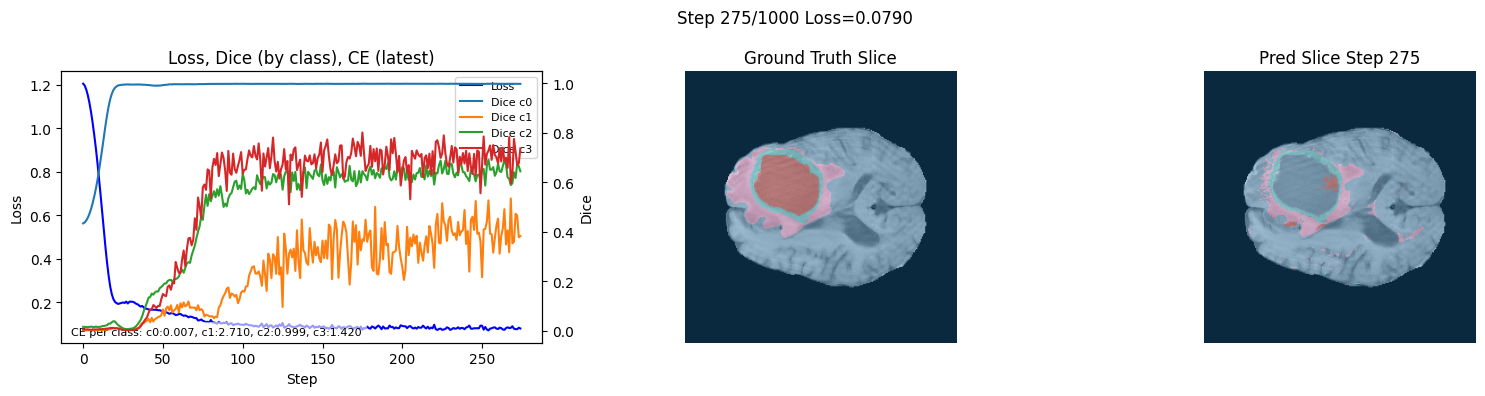

KeyboardInterrupt: 

In [8]:
from IPython.display import clear_output, display
loss_history = []
dice_history = [[] for _ in range(NUM_CLASSES)]
ce_history = [[] for _ in range(NUM_CLASSES)]
start = time.time()

# Quick slice prediction helper
H = train_mods.shape[2]
W = train_mods.shape[3]
D = train_mods.shape[4]
mid_z = D//2

def predict_slice(params, case_index=VAL_CASE_INDEX, z=mid_z):
    xs = jnp.arange(H)
    ys = jnp.arange(W)
    X,Y = jnp.meshgrid(xs, ys, indexing='ij')  # (H,W)
    x_flat = X.reshape(-1)
    y_flat = Y.reshape(-1)
    z_flat = jnp.full_like(x_flat, z)
    coords = jnp.stack([x_flat, y_flat, z_flat], axis=-1)
    norm_coords = (coords / (jnp.array([H-1, W-1, D-1]))) * 2.0 - 1.0
    intens = train_mods[case_index, :, x_flat, y_flat, z]
    x_in = build_input(norm_coords, intens)
    logits = apply_mlp(params, x_in)
    pred = jnp.argmax(logits, axis=-1)
    return pred.reshape(H,W)

# Cache ground truth slice for faster display
true_slice = train_segs[VAL_CASE_INDEX, :, :, mid_z]
mod0_slice = train_mods[VAL_CASE_INDEX, 0, :, :, mid_z]

for step in range(1, TRAIN_STEPS+1):
    jax_key, step_key = jax.random.split(jax_key)
    params, opt_state, loss_val, aux = microbatch_step(params, opt_state, step_key)
    loss_history.append(float(loss_val))
    dice_k = aux['dice_per_class']
    ce_k = aux['ce_per_class']
    for k in range(NUM_CLASSES):
        dice_history[k].append(float(dice_k[k]))
        ce_history[k].append(float(ce_k[k]))

    if step % 25 == 0 or step == 1:
        # Predict single slice
        pred_slice = predict_slice(params)
        clear_output(wait=True)
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1,3, figsize=(16,4))
        # Loss + per-class dice
        ax0 = axes[0]
        ax0.plot(loss_history, color='blue', label='Loss')
        ax0.set_title('Loss, Dice (by class), CE (latest)')
        ax0.set_xlabel('Step')
        ax0.set_ylabel('Loss')
        ax1 = ax0.twinx()
        colors = plt.cm.tab10.colors
        latest_ce = [h[-1] if h else float('nan') for h in ce_history]
        for k in range(NUM_CLASSES):
            ax1.plot(dice_history[k], label=f'Dice c{k}', color=colors[k % len(colors)])
        ax1.set_ylabel('Dice')
        # Add CE per-class as text box
        ce_text = 'CE per class: ' + ', '.join([f'c{k}:{latest_ce[k]:.3f}' for k in range(NUM_CLASSES)])
        ax0.text(0.02, 0.02, ce_text, transform=ax0.transAxes, fontsize=8, va='bottom', ha='left', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        # Combine legends
        lines0, labels0 = ax0.get_legend_handles_labels()
        lines1, labels1 = ax1.get_legend_handles_labels()
        ax0.legend(lines0 + lines1, labels0 + labels1, loc='upper right', fontsize=8)
        # Images
        axes[1].imshow(mod0_slice, cmap='gray')
        axes[1].imshow(true_slice, alpha=0.35, cmap='tab10')
        axes[1].set_title('Ground Truth Slice')
        axes[1].axis('off')
        axes[2].imshow(mod0_slice, cmap='gray')
        axes[2].imshow(pred_slice, alpha=0.35, cmap='tab10')
        axes[2].set_title(f'Pred Slice Step {step}')
        axes[2].axis('off')
        fig.suptitle(f'Step {step}/{TRAIN_STEPS} Loss={loss_val:.4f}')
        plt.tight_layout()
        display(fig)
        plt.close(fig)
print(f'Training time: {time.time()-start:.2f}s')


## Evaluation (Reconstruct Full Segmentation for One Case)
We reconstruct the segmentation by querying the model on all voxel coordinates of the validation case (chosen by VAL_CASE_INDEX). Then compute Dice per class. To avoid memory overflow, we chunk coordinates.

In [ ]:
def predict_volume(params, case_data, chunk=200000):
    mods = case_data['mods']  # (M,H,W,D)
    seg_true = case_data['seg']
    M, H, W, D = mods.shape
    # Build coordinate grid
    xs, ys, zs = np.arange(H), np.arange(W), np.arange(D)
    grid = np.stack(np.meshgrid(xs, ys, zs, indexing='ij'), axis=-1).reshape(-1,3)  # (N,3)
    intens = mods.transpose(1,2,3,0).reshape(-1, M)  # align with grid
    # Normalize coords
    norm_coords = (grid / np.array([H-1, W-1, D-1])) * 2.0 - 1.0
    preds = []
    for i in range(0, len(grid), chunk):
        c_chunk = jnp.array(norm_coords[i:i+chunk])
        f_chunk = jnp.array(intens[i:i+chunk])
        x_in = build_input(c_chunk, f_chunk)
        logits = apply_mlp(params, x_in)
        cls = jnp.argmax(logits, axis=-1)
        preds.append(np.array(cls, dtype=np.int16))
    pred_flat = np.concatenate(preds, axis=0)
    pred_vol = pred_flat.reshape(H, W, D)
    return pred_vol, seg_true

def dice_score(pred, true, num_classes):
    scores = {}
    for c in range(num_classes):
        pred_c = (pred == c)
        true_c = (true == c)
        inter = (pred_c & true_c).sum()
        denom = pred_c.sum() + true_c.sum()
        dice = (2*inter + 1e-6) / (denom + 1e-6) if denom > 0 else np.nan
        scores[c] = dice
    return scores

# Choose a validation case if available, otherwise fallback to a training case
if val_cache and len(val_cache) > 0:
    chosen_case = val_cache[min(VAL_CASE_INDEX, len(val_cache)-1)]
    chosen_set = 'validation'
else:
    chosen_case = train_cache[min(VAL_CASE_INDEX, len(train_cache)-1)]
    chosen_set = 'training'

pred_vol, true_vol = predict_volume(params, chosen_case, chunk=120000)
scores = dice_score(pred_vol, true_vol, NUM_CLASSES)
print(f'Dice scores ({chosen_set} set):', scores)


## Visualization (Middle Slices)
We show all modalities with ground-truth and predicted segmentation overlays.


In [ ]:
import matplotlib.pyplot as plt
mid_z = pred_vol.shape[2]//2
import numpy as _np

def _dice_macro_slice(pred2d, true2d, num_classes=4):
    scores = []
    for c in range(num_classes):
        p = (pred2d == c)
        t = (true2d == c)
        inter = (p & t).sum()
        denom = p.sum() + t.sum()
        if denom > 0:
            scores.append((2*inter + 1e-6) / (denom + 1e-6))
    return float(_np.mean(scores)) if len(scores)>0 else float('nan')

def _psnr_slice(pred2d, true2d, max_val=3.0):
    mse = _np.mean((_np.asarray(pred2d, dtype=_np.float32) - _np.asarray(true2d, dtype=_np.float32))**2)
    if mse <= 1e-12:
        return float('inf')
    return float(10.0 * _np.log10((max_val*max_val) / (mse + 1e-12)))

def visualize_modalities_with_overlays(mods, seg_gt, seg_pred, z):
    M = mods.shape[0]
    fig, axes = plt.subplots(2, M, figsize=(3*M, 6))
    if M == 1:
        axes = _np.array([[axes[0]],[axes[1]]], dtype=object)
    for m in range(M):
        ax_gt = axes[0, m]
        ax_pred = axes[1, m]
        # Ground truth overlay
        ax_gt.imshow(mods[m,:,:,z], cmap='gray')
        ax_gt.imshow(seg_gt[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3)
        ax_gt.set_title(f'Mod {m} + GT', fontsize=10)
        ax_gt.axis('off')
        # Prediction overlay with metrics annotation box
        ax_pred.imshow(mods[m,:,:,z], cmap='gray')
        ax_pred.imshow(seg_pred[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3)
        d = _dice_macro_slice(seg_pred[:,:,z], seg_gt[:,:,z], num_classes=4)
        p = _psnr_slice(seg_pred[:,:,z], seg_gt[:,:,z], max_val=3.0)
        ax_pred.set_title(f'Mod {m} + Pred', fontsize=10)
        ax_pred.text(0.01, 0.99, f'Dice {d:.3f} PSNR {p:.2f} dB',
                   transform=ax_pred.transAxes, ha='left', va='top', fontsize=8,
                   color='yellow', bbox=dict(boxstyle='round', fc='black', alpha=0.5, pad=0.4))
        ax_pred.axis('off')
    plt.tight_layout()
    plt.show()

# Show current validation case slice with metrics (non-overlapping)
visualize_modalities_with_overlays(chosen_case['mods'], true_vol, pred_vol, mid_z)


## Save Parameters
We save learned parameters for reuse.

In [ ]:
flat_params = {}
for i, layer in enumerate(params):
    flat_params[f'W_{i}'] = np.array(layer['W'])
    flat_params[f'b_{i}'] = np.array(layer['b'])
np.savez_compressed(SAVE_PATH, **flat_params)
print('Saved parameters to', SAVE_PATH)


## Next Steps
- Increase TRAIN_STEPS, CASE_LIMIT for better accuracy.
- Add class rebalancing or focal loss (BraTS class imbalance).
- Integrate data augmentations (intensity shifts, coordinate jitter).
- Compare against nnU-Net baseline metrics.
- Explore multi-resolution coordinate conditioning or SIREN activations.

## Hold-Out Case Evaluation
We evaluate the model on a case not included in the training subset (beyond CASE_LIMIT). If unavailable, we skip.


In [ ]:
all_cases_full = find_cases(DATA_ROOT)
extra_cases = all_cases_full[CASE_LIMIT:]
print('Hold-out cases available:', len(extra_cases))
if len(extra_cases) > 0:
    hold_case_path = extra_cases[1]
    hold_mods, hold_seg = load_case(hold_case_path)
    hold_case_data = {'mods': hold_mods, 'seg': hold_seg}
    hold_pred, hold_true = predict_volume(params, hold_case_data, chunk=120000)
    hold_scores = dice_score(hold_pred, hold_true, NUM_CLASSES)
    print('Hold-out Dice:', hold_scores)
    mid_z_hold = hold_pred.shape[2]//2
    visualize_modalities_with_overlays(hold_mods, hold_true, hold_pred, mid_z_hold)
else:
    print('No hold-out case beyond training CASE_LIMIT to evaluate.')


## Interactive Viewer (Hold-outs)
Use the dropdown to select a hold-out case and slider to browse slices. The layout (all modalities with GT and Pred overlays) remains fixed; only the slice changes.

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pathlib as _pl

# Prepare hold-out cases list
all_cases_full = find_cases(DATA_ROOT)
extra_cases = all_cases_full[CASE_LIMIT:]
case_options = [(p.name, str(p)) for p in extra_cases]
print('Hold-out cases:', len(case_options))

hold_pred_cache = {}  # path -> pred volume
state = {'mods': None, 'true': None, 'pred': None}

def load_and_predict_cached(case_path_str):
    p = _pl.Path(case_path_str)
    mods, seg = load_case(p)
    if case_path_str not in hold_pred_cache:
        pred, _ = predict_volume(params, {'mods': mods, 'seg': seg}, chunk=120000)
        hold_pred_cache[case_path_str] = pred
    return mods, seg, hold_pred_cache[case_path_str]

out = widgets.Output()
if len(case_options) == 0:
    print('No hold-out cases available to visualize.')
else:
    dd_hold = widgets.Dropdown(options=case_options, description='Hold-out:')
    # Initialize
    state['mods'], state['true'], state['pred'] = load_and_predict_cached(dd_hold.value)
    z_slider = widgets.IntSlider(min=0, max=int(state['pred'].shape[2]-1), value=int(state['pred'].shape[2]//2), description='Slice z')

    def render_slice(z):
        with out:
            clear_output(wait=True)
            visualize_modalities_with_overlays(state['mods'], state['true'], state['pred'], int(z))

    def on_slice_change(change):
        render_slice(change['new'])

    def on_case_change(change):
        state['mods'], state['true'], state['pred'] = load_and_predict_cached(change['new'])
        z_slider.max = int(state['pred'].shape[2]-1)
        z_slider.value = int(state['pred'].shape[2]//2)
        render_slice(z_slider.value)

    z_slider.observe(on_slice_change, names='value')
    dd_hold.observe(on_case_change, names='value')
    display(widgets.VBox([dd_hold, z_slider, out]))
    render_slice(z_slider.value)
